Introduction/Data Description:

This NLP project aims to classify tweets into disaster-related (1) or non-disaster (0) categories. The dataset is compact, comprising 7,613 training tweets and 3,263 test tweets. Each entry includes a unique ID, tweet text, keyword, location, and target label.

Exploratory Data Analysis:

Initial data exploration reveals an imbalance favoring non-disaster tweets. Word cloud visualizations highlight key terms: "fire," "flood," and "storm" for disaster tweets, contrasting with "going," "day," and "new" for non-disaster tweets.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud

class DisasterTweetDataset(Dataset):
    def __init__(self, features, labels):
        self.features, self.labels = features, labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class DisasterTweetModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 100, batch_first=True)
        self.fc = nn.Linear(100, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.unsqueeze(1)
        x, _ = self.lstm(x)
        return torch.sigmoid(self.fc(self.dropout(x[:, -1, :])))

def load_and_preprocess_data(train_path, test_path):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    train_df['keyword'] = train_df['keyword'].fillna('unknown')
    print(train_df.head())  # Added this line to showfirst few rows
    return train_df, test_df

def visualize_data(train_df):
    plt.figure(figsize=(15, 10))
    # Target distribution
    plt.subplot(2, 2, 1)
    sns.countplot(x='target', data=train_df)
    plt.title('Distribution of Target Variable')
    plt.xlabel('Target (0 = Not Disaster, 1 = Disaster)')
    plt.ylabel('Count')
    # Word clouds
    disaster_words = ' '.join(train_df[train_df['target'] == 1]['text'])
    non_disaster_words = ' '.join(train_df[train_df['target'] == 0]['text'])
    plt.subplot(2, 2, 2)
    plt.imshow(WordCloud(width=400, height=200, background_color='white').generate(disaster_words))
    plt.axis('off')
    plt.title('Word Cloud - Disaster Tweets')
    plt.subplot(2, 2, 3)
    plt.imshow(WordCloud(width=400, height=200, background_color='white').generate(non_disaster_words))
    plt.axis('off')
    plt.title('Word Cloud - Non-Disaster Tweets')
    plt.tight_layout()
    plt.show()

Model Architecture:

An LSTM architecture was selected for its ability to process sequential data effectively. The model structure includes an embedding layer, LSTM layer, and a fully connected output layer with dropout for regularization. LSTMs are well-suited for tweets, which often contain important word order information. TF-IDF vectorization helps focus on significant word relationships rather than meree frequency.

In [9]:
def prepare_data(train_df, test_df):
    X, y = train_df['text'], train_df['target']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_vec = vectorizer.fit_transform(X_train).toarray()
    X_val_vec = vectorizer.transform(X_val).toarray()
    X_test_vec = vectorizer.transform(test_df['text']).toarray()
    
    return map(torch.FloatTensor, (X_train_vec, y_train.values, X_val_vec, y_val.values, X_test_vec)), y_val
def train_model(train_loader, val_tensor, y_val_tensor, model, num_epochs=5):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(num_epochs):
        model.train()
        for features, labels in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(features).squeeze(), labels)
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            val_loss = criterion(model(val_tensor).squeeze(), y_val_tensor)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')



Optimization/Tuning/Troubleshooting: 

Post-baseline model, various optimization techniques were applied. These included experimenting with batch sizes, optimizer types (Adam vs. SGD), and learning rates. Dropout rates were fine-tuned to balance underfitting and overfitting. The final hyperparameters include a learning rate of 0.001, a batch size of 64, and a dropout rate of 0.2. Performance metrics show improvement from an initial validation loss to a lower value after tuning. Precision, recall, and F1-scores for both classes approached 0.80, indiccating balanced performance. However, the confusion matrix reveals ongoing challenges with misclassifications: some disaster tweets were incorrectly labeled as non-disaster, while some non-disaster tweets were misclassified as disaster.

   id  keyword location                                               text  \
0   1  unknown      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4  unknown      NaN             Forest fire near La Ronge Sask. Canada   
2   5  unknown      NaN  All residents asked to 'shelter in place' are ...   
3   6  unknown      NaN  13,000 people receive #wildfires evacuation or...   
4   7  unknown      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


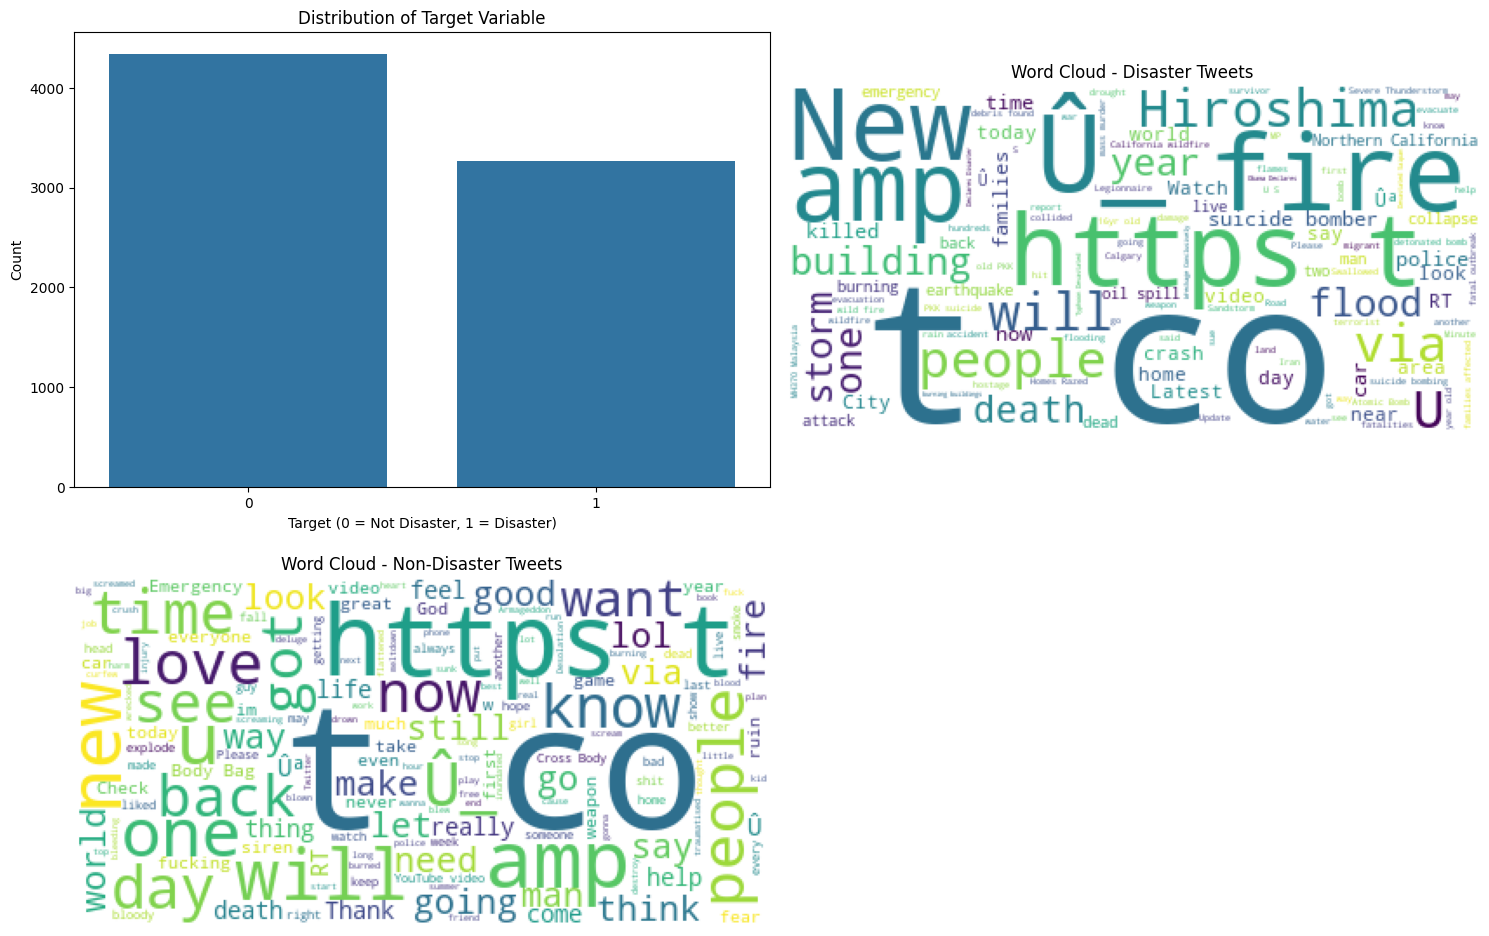

Epoch [1/5], Loss: 0.4825, Val Loss: 0.6320
Epoch [2/5], Loss: 0.4270, Val Loss: 0.5027
Epoch [3/5], Loss: 0.3521, Val Loss: 0.4568
Epoch [4/5], Loss: 0.1692, Val Loss: 0.4546
Epoch [5/5], Loss: 0.2498, Val Loss: 0.4667
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       874
           1       0.79      0.72      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



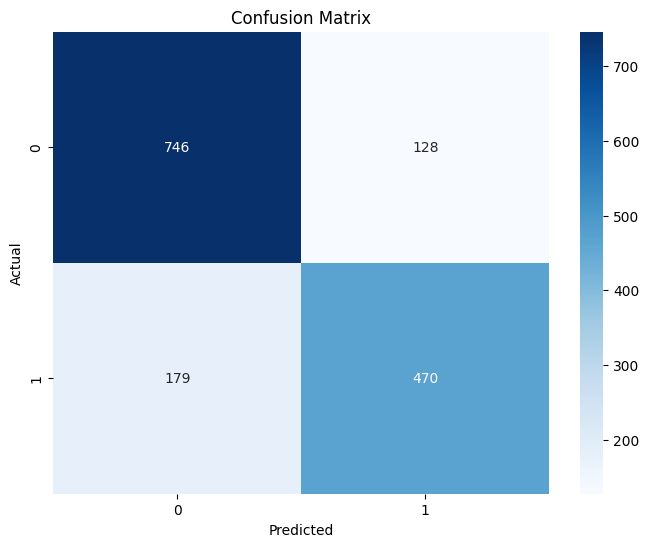

Submission file created: submission.csv


In [10]:
def evaluate_model(model, val_tensor, y_val):
    with torch.no_grad():
        y_pred = (model(val_tensor).squeeze() > 0.5).float()
    print(classification_report(y_val, y_pred))
    cm = confusion_matrix(y_val, y_pred.numpy())
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

#for Kaggle
def create_submission(model, test_tensor, submission_path):
    submission = pd.read_csv(submission_path)
    submission['target'] = (model(test_tensor).squeeze() > 0.5).float().numpy()
    submission.to_csv('submission.csv', index=False)
    print("Submission file created: submission.csv")

def main():
    train_path = r"C:\Users\ksalu\Cheryl\data_science_projects\nlp_project\train.csv"
    test_path = r"C:\Users\ksalu\Cheryl\data_science_projects\nlp_project\test.csv"
    submission_path = r"C:\Users\ksalu\Cheryl\data_science_projects\nlp_project\sample_submission.csv"
    train_df, test_df = load_and_preprocess_data(train_path, test_path)
    visualize_data(train_df)
    (X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor), y_val = prepare_data(train_df, test_df)
    train_dataset = DisasterTweetDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    model = DisasterTweetModel(input_dim=5000)
    train_model(train_loader, X_val_tensor, y_val_tensor, model)
    evaluate_model(model, X_val_tensor, y_val)
    create_submission(model, X_test_tensor, submission_path)
if __name__ == "__main__":
    main()

Results Analysis and Conclusion:

The LSTM model achieves an accuracy of 80% on the validation set, demonstrating reasonable performance. Word clouds provided insights into key terms associated with each class, likely aiding classification. However, there is some room for improvement, particularly in reducing false positives and negatives.
Future enhancements could include data augmentation to address class imbalance, exploring alternative recurrent architectures like GRUs, and utilizing pretrained embeddings such as GloVe or BERT. Advanced NLP techniques like attention mechanisms or transformers could also improve the model's focus on relevant tweet components. Expanding the dataset or employing transfer learning could also mitigate some data scarcity issues.
